In [1]:
import torch
import torchvision.models as models
from PIL import Image, ImageTk
import numpy as np
from preprocess import Box
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import PySimpleGUI as sg
import io

In [6]:
class BoxDataset(Dataset):
    """
    Dataset for managing the images (containing text) extracted by our model
    _and_ the bounding box information from the first pass with tesseract
    """

    def __init__(self, inp_path):
        self.inp_path = inp_path
        self.fout = open(f"{inp_path}/meta.txt", "r")
        self.lines = self.fout.readlines()
        # Wrangles to proper format for mobilenet
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        data = self.lines[idx].split(",")
        timestamp = data[0]
        box_id = data[1]
        raw_box = ",".join(data[2:])
        box = Box.from_str(raw_box)
        key = f"{timestamp}_{box_id}"
        raw_img = Image.open(f"{self.inp_path}/color/{key}.jpg")
        img = self.transform(raw_img)
        return {
            "id": box_id,
            "left": box.left,
            "top": box.top,
            "width": box.width,
            "height": box.height,
            "timestamp": timestamp,
            "img": img,
        }
    
    def __del__(self):
        print(self.fout)
        self.fout.close()

In [34]:
class Labeller:
    """
    Manages a GUI that randomly solicits targeted labels from the user to get
    good labels of the entire box space
    """

    def __init__(
            self, 
            color_dir, 
            ix2box,
            ix2timestamp,
            pca_results,
            distance_threshold=50,
            give_up_after=5,
            min_num_label=10
        ):
        self.color_dir = color_dir
        self.ix2box = ix2box
        self.ix2timestamp = ix2timestamp
        self.pca_results = pca_results
        self.distance_threshold = distance_threshold
        self.give_up_after = give_up_after
        self.min_num_label = min_num_label

        # Setup the candidate info
        self.candidate_ix = -1
        self.used_labels = ["none"]
        self.entry_ix = 0
        self.labelled = {}
        self.get_new_candidate()

        # Configure GUI
        self.image_elem = sg.Image(data=self.get_image_data(self.get_candidate_file(), is_first=True))
        self.label_col = [
            [sg.Listbox(values=self.used_labels, enable_events=True, size=(20, 10), font=('Arial Bold', 20), key='listbox')],
            [sg.Input('', enable_events=True, key='new_label', font=('Arial Bold', 20), expand_x=True, justification='left')],
            [sg.Button('Select', size=(8, 2))]
        ]
        self.image_col = [[self.image_elem]]
        layout = [[sg.Column(self.label_col), sg.Column(self.image_col)]]
        self.window = sg.Window(
            'Labeller',
            layout,
            return_keyboard_events=True,
            location=(0, 0),
            use_default_focus=False,
            size=(1200, 850),
        )

        # Final label info
        self.label2ixs = {}
        self.ix2label = {}
    
    def get_candidate_file(self):
        box = self.ix2box[self.candidate_ix]
        timestamp = self.ix2timestamp[self.candidate_ix]
        return f"{self.color_dir}/{timestamp}_{box.id}.jpg"
    
    def get_image_data(self, filename, maxsize=(800,800), is_first=False):
        pil_image = Image.open(filename)
        pil_image.thumbnail(maxsize)
        if is_first:
            bio = io.BytesIO()
            pil_image.save(bio, format="PNG")
            del pil_image
            return bio.getvalue()
        return ImageTk.PhotoImage(pil_image)

    def get_new_candidate(self):
        # Randomly selects a new candidate or terminates if none are found
        for count in range(self.give_up_after):
            self.entry_ix += 1
            too_close = False
            for other_ix in self.labelled.keys():
                this_pca = self.pca_results[self.entry_ix]
                other_pca = self.pca_results[other_ix]
                dist = np.linalg.norm(this_pca - other_pca)
                if dist < self.distance_threshold:
                    too_close = True
                    break
            if too_close:
                continue
            self.candidate_ix = self.entry_ix
            return True
        return False

    def run(self):
        while True:
            data = self.window.read()
            if data == None:
                continue
            event, values = data
            # perform button and keyboard operations
            if event == sg.WIN_CLOSED:
                break
            elif event == 'Select':
                if len(values['listbox']) == 0 and len(values['new_label']) == 0:
                    continue
                elif len(values['new_label']) > 0:
                    label = values['new_label']
                else:
                    label = values['listbox'][0]
                self.labelled[self.candidate_ix] = label
                found = self.get_new_candidate()
                if not found and len(self.labelled) >= self.min_num_label:
                    break
                self.image_elem.update(data=self.get_image_data(self.get_candidate_file()))
                if label not in self.used_labels:
                    self.used_labels.append(label)
                    self.window['listbox'].update(values=self.used_labels)
        self.window.close_destroys_window = True
        self.window.close()
    
    def plot_user_labeled(self, title, explained_x, explained_y):
        ixs = list(self.labelled.keys())
        labels = [self.labelled[ix] for ix in ixs]
        plt.scatter(self.pca_results[ixs, 0], self.pca_results[ixs, 1])
        plt.xlabel(f"PC1 ({explained_x * 100:.2f}%)")
        plt.ylabel(f"PC2 ({explained_y * 100:.2f}%)")
        plt.title(title)
    
    def finalize_labels(self):
        for ix in range(len(self.pca_results)):
            result = ""

            if ix in self.labelled:
                result = self.labelled[ix]
            else:
                # Find the closest label
                min_distance = np.inf
                min_label = None
                for labelled_ix in self.labelled.keys():
                    this_pca = self.pca_results[ix]
                    other_pca = self.pca_results[labelled_ix]
                    distance = np.linalg.norm(this_pca - other_pca)
                    if distance < min_distance:
                        min_distance = distance
                        min_label = self.labelled[labelled_ix]
                result = min_label
            
            if result not in self.label2ixs:
                self.label2ixs[result] = []
            self.label2ixs[result].append(ix)
            self.ix2label[ix] = result
    
    def plot_all_labelled(self, title, explained_x, explained_y):
        for label, ixs in self.label2ixs.items():
            plt.scatter(self.pca_results[ixs, 0], self.pca_results[ixs, 1], label=label)
        plt.legend()
        plt.xlabel(f"PC1 ({explained_x * 100:.2f}%)")
        plt.ylabel(f"PC2 ({explained_y * 100:.2f}%)")
        plt.title(title)

In [8]:
class Classifier:
    """
    Performs transfer-learning inference on-top of mobilenet and then
    dimensionality reduction using PCA to put our boxes into a space
    we can more easily work with
    """
    def __init__(self, box_dir: str, PCA_components=2):
        self.box_dir = box_dir

        # Get the dataset and loaders
        self.shape_ds = BoxDataset(f"{box_dir}")
        self.shape_loader = DataLoader(self.shape_ds, batch_size=1, shuffle=True)

        # Convenient mappings to have around
        self.ix2box = {}
        self.ix2timestamp = {}
        self.timestamp2ix = {}
        pbar = tqdm(total=len(self.shape_loader))
        for (ix, item) in enumerate(self.shape_loader):
            box = Box(
                id=item["id"][0],
                left=item["left"][0],
                top=item["top"][0],
                width=item["width"][0],
                height=item["height"][0]
            )
            self.ix2box[ix] = box
            self.ix2timestamp[ix] = item["timestamp"][0]
            self.timestamp2ix[item["timestamp"][0]] = ix
            pbar.update(1)
        pbar.close()

        # Set up for PCA stuff
        self.PCA_components = PCA_components
        self.outputs = []
        self.pca_results = []
        self.pca_components = None
        self.explained_variance_ratios = None

    def do_PCA(self):
        # Force ourselves to use CPU to support users without crazy GPUs
        device = torch.device('cpu')
        mobilenet_pretrained = models.mobilenet_v2(pretrained=True).to(device) 
        pbar = tqdm(total=len(self.shape_loader))
        output_list = []
        for (ix, item) in enumerate(self.shape_loader):
            img = item["img"]
            features = mobilenet_pretrained.features(img)
            # Perform max pooling
            features = torch.max(features, dim=3)[0]
            features = torch.max(features, dim=2)[0]
            # Attach height and width information
            # NOTE: Obtained better results by tuning contribution here
            features = torch.cat((features, torch.tensor([[item["width"] / 20, item["height"] / 20]])), dim=1)
            output_list.append(features.detach().numpy())
            pbar.update(1)
        pbar.close()
        raw_outputs = np.concatenate(output_list)
        num_samples, num_features = raw_outputs.shape[0], np.prod(raw_outputs.shape[1:])
        self.outputs = raw_outputs.reshape(num_samples, num_features)
        pca = PCA(n_components=self.PCA_components)
        self.pca_results = pca.fit_transform(self.outputs)
        self.explained_variance_ratios = pca.explained_variance_ratio_
    
    def plot_PCA(self):
        plt.scatter(self.pca_results[:, 0], self.pca_results[:, 1])
        plt.xlabel(f"PC1 ({self.explained_variance_ratios[0] * 100:.2f}%)")
        plt.ylabel(f"PC2 ({self.explained_variance_ratios[1] * 100:.2f}%)")
        plt.show()


100%|██████████| 2677/2677 [00:15<00:00, 176.76it/s]
/Users/mork/anaconda3/envs/kino/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mork/anaconda3/envs/kino/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2677/2677 [02:57<00:00, 15.08it/s]


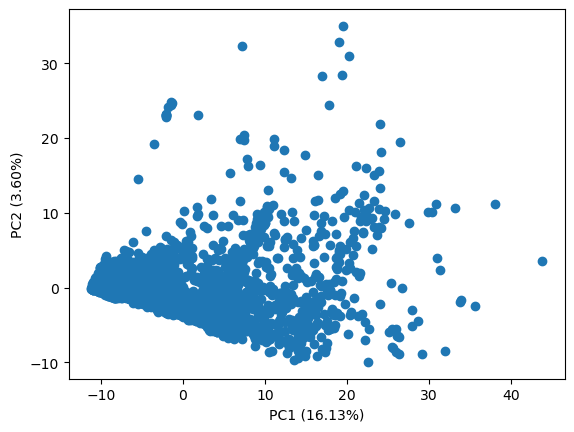

In [10]:
classifier = Classifier("jankos/boxes")
classifier.do_PCA()
classifier.plot_PCA()

In [35]:
labeller = Labeller(
    "jankos/boxes/color",
    classifier.ix2box,
    classifier.ix2timestamp,
    classifier.pca_results,
    distance_threshold=1,
    give_up_after=10,
    min_num_label=10
)
labeller.run()

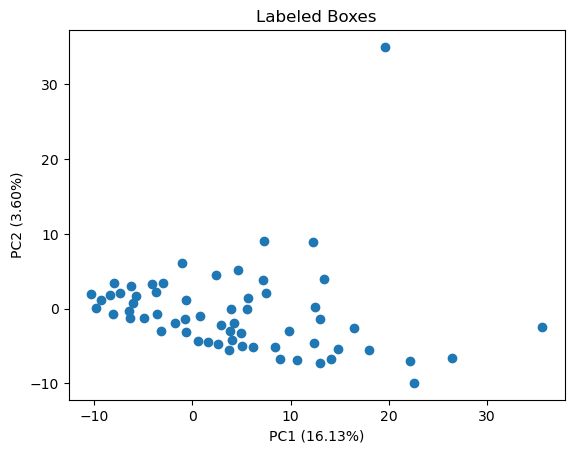

In [36]:
labeller.plot_user_labeled("Labeled Boxes", explained_x=classifier.explained_variance_ratios[0], explained_y=classifier.explained_variance_ratios[1])

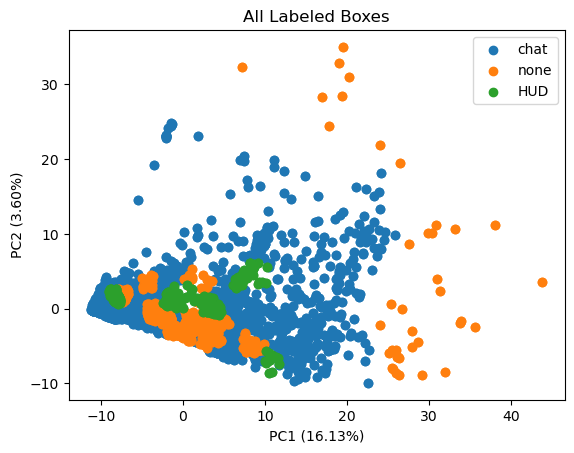

: 

In [38]:
labeller.finalize_labels()
labeller.plot_all_labelled("All Labeled Boxes", explained_x=classifier.explained_variance_ratios[0], explained_y=classifier.explained_variance_ratios[1])